# Single-cell RNA-seqs analysis using Python  
## Exercises 01: Raw reads to expression matrix

## 1. Raw data processing
__Experiment:__ [E-MTAB-6945](https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-6945)  
__Dataset:__ Raw scRNA-seq reads from T-cells of mouse neonate thymus, subset of one sample (400k reads)  
__Technology:__ Drop-seq

Reads can be obtained from the links below.  
https://zenodo.org/record/4574153/files/SLX-7632.TAAGGCGA.N701.s_1.r_1.fq-400k.fastq  
https://zenodo.org/record/4574153/files/SLX-7632.TAAGGCGA.N701.s_1.r_2.fq-400k.fastq  

Both reads and references are pre-donwloaded and saved in the following locations in the VMs:
```
data_dir="../../training_data"
fastq_dir="${data_dir}/ex_read_fastq"
ref_dir="${data_dir}/ex_mouse_ref"
```

__Instructions:__ Write and run a script that executes raw data processing on the given data set.  One may run the full alevin-fry workflow, or the simpler `simpleaf` method.  There is no unfiltered permit list file for drop-seq experiments, so use one of the other barcode correction methods when generating a barcode permit list.  

### Questions  
1.  Which fastq file contains the cell barcodes + UMIs, and which contains the transcript sequences?  
2.  How long is the cell barcode and how long is the UMI?  
3.  What is the length of the transcript reads?  
4.  How many barcodes do you end up with after quantification?  
5.  How many genes are included in your quantification results?  

### Questions & __Answers__  
1.  Which fastq file contains the cell barcodes + UMIs, and which contains the transcript sequences?  __read1 has CB+UMIs, read2 has transcript seqiences__  
3.  How long is the cell barcode and how long is the UMI? __CB is 12 bp, UMI is 8 bp__  
4.  What is the length of the transcript reads? __98 bp__  
5.  How many barcodes do you end up with after quantification? __61,328 barcodes: alevin-fry method, using `-f 100000` in `alevin-fry generate-permit-list` and `alevin-fry quant` using `cr-like` UMI resolution method; 23,247 barcodes: same method, but `--knee-distance` in `alevin-fry generate-permit-list`__  
6.  How many genes are included in your quantification results? __77,430 genes: same method as above__  

## 2.  Quality Control  
Perform QC, use conda env `sc_py_training`.  Compose commands below as instructed, to complete the QC processing.  Answer questions at the bottom of the section.  

### 2.1 Filtering low quality barcodes

In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

Complete command below to open the dataset as an annData object.  The data is saved in `../../training_data/E-MTAB-6945.h5ad`

In [2]:
# For exercises, we are using the raw counts of E-MTAB-6945 (not the subset)
# adata = sc.read()
adata = sc.read("../../training_data/E-MTAB-6945.h5ad")
adata

AnnData object with n_obs × n_vars = 5218 × 35682
    obs: 'age', 'cell_type', 'developmental_stage', 'disease', 'genotype', 'individual', 'organism_part', 'organism', 'sex', 'strain', 'genotype.1', 'age_ontology', 'cell_type_ontology', 'developmental_stage_ontology', 'disease_ontology', 'genotype_ontology', 'individual_ontology', 'organism_part_ontology', 'organism_ontology', 'sex_ontology', 'strain_ontology', 'genotype_ontology.1'
    var: 'gene_symbols', 'chromosome', 'start', 'end', 'width', 'source', 'type', 'score', 'phase', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'mito'

In [3]:
# Mitochondrial transcripts are already annotated
adata.var.loc[adata.var.chromosome == "MT", ["gene_symbols", "chromosome", "mito"]] 

,gene_symbols,chromosome,mito
ENSMUSG00000064341,mt-Nd1,MT,True
ENSMUSG00000064345,mt-Nd2,MT,True
ENSMUSG00000064351,mt-Co1,MT,True
ENSMUSG00000064354,mt-Co2,MT,True
ENSMUSG00000064356,mt-Atp8,MT,True
ENSMUSG00000064357,mt-Atp6,MT,True
ENSMUSG00000064358,mt-Co3,MT,True
ENSMUSG00000064360,mt-Nd3,MT,True
ENSMUSG00000065947,mt-Nd4l,MT,True
ENSMUSG00000064363,mt-Nd4,MT,True


Below, calculate qc metrics, and include variable indicating whether or not a gene is mitochondrials as a variable to control for.

In [4]:
# sc.pp.calculate_qc_metrics(
#     adata, qc_vars=[], inplace=True, percent_top=[20], log1p=True
# )
# adata
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mito"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 5218 × 35682
    obs: 'age', 'cell_type', 'developmental_stage', 'disease', 'genotype', 'individual', 'organism_part', 'organism', 'sex', 'strain', 'genotype.1', 'age_ontology', 'cell_type_ontology', 'developmental_stage_ontology', 'disease_ontology', 'genotype_ontology', 'individual_ontology', 'organism_part_ontology', 'organism_ontology', 'sex_ontology', 'strain_ontology', 'genotype_ontology.1', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'gene_symbols', 'chromosome', 'start', 'end', 'width', 'source', 'type', 'score', 'phase', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In the third plot below, show the log-transformed versions of the `total_counts` and `n_genes_by_counts` in their respective axes.

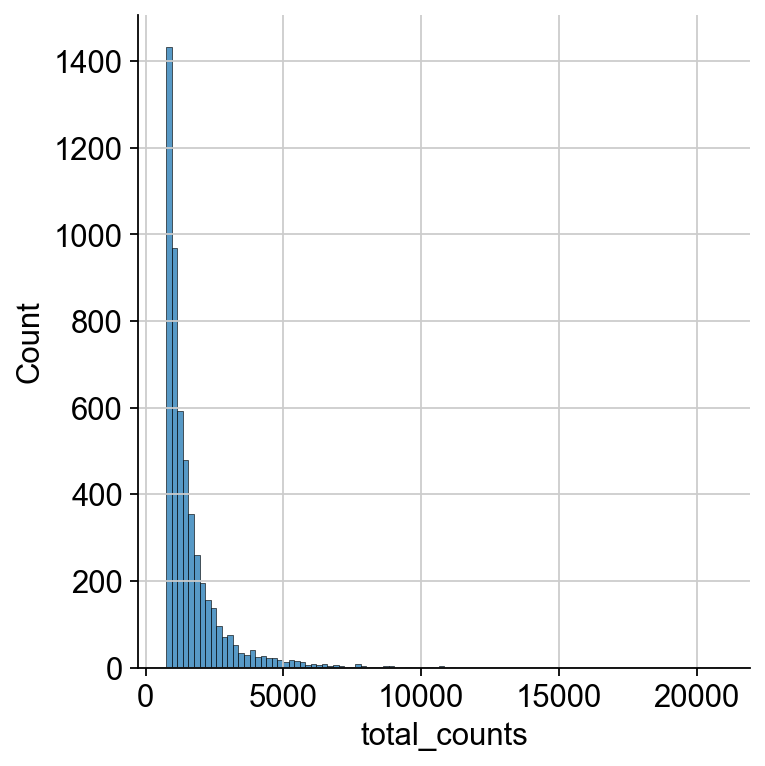

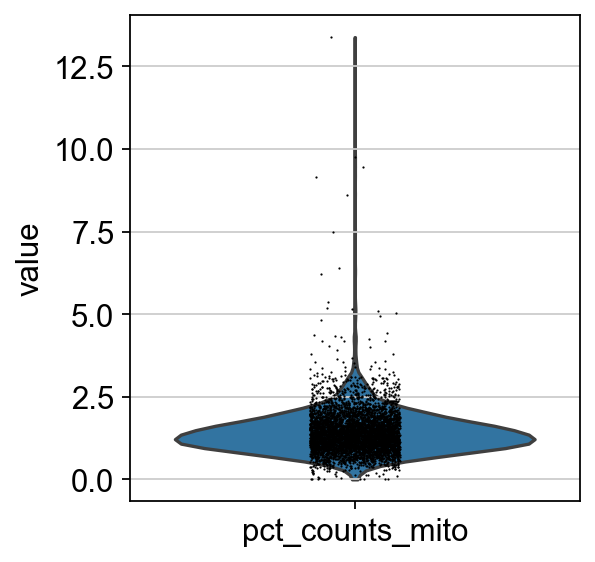

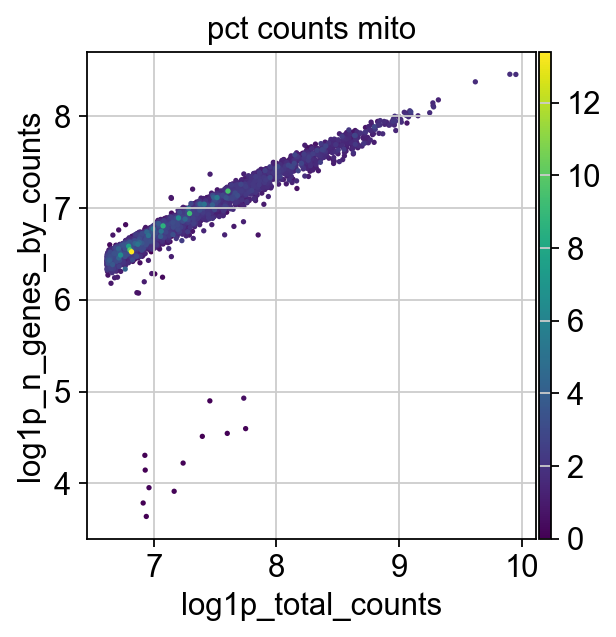

In [5]:
# Ditribution of barcodes (cells) in terms of the numbr of genes per barcode (cell)
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# Above distribution viewed as a violon plot:
# sc.pl.violin(adata, 'total_counts')

# Distribution of barcodes (cells) in terms of the %mt of counts per barcode (cell)
p2 = sc.pl.violin(adata, "pct_counts_mito")

# A scatter representing total_counts (x), n_genes_by_counts (y), and %mt of counts (color) per barcode (cell)
# p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mito")
p3 = sc.pl.scatter(adata, "log1p_total_counts", "log1p_n_genes_by_counts", color="pct_counts_mito")

Below is a function that evaluates whether or not a value is an outlier.

In [6]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

Create a boolean series where outliers are based on metrics `log1p_total_counts`, `log1p_n_genes_by_counts`, and`pct_counts_in_top_20_genes`. Use `nmads = 5`

In [7]:
# adata.obs["outlier"] = ()
# adata.obs.outlier.value_counts()

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    5064
True      154
Name: count, dtype: int64

Create a series of booleans indicating whether observations or barcodes are outliers based on `nmads = 6`.  Do not save the boolean series within the annData object.  

In [8]:
outliers_6nmad = (
    is_outlier(adata, "log1p_total_counts", 6)
    | is_outlier(adata, "log1p_n_genes_by_counts", 6)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 6)
)
outliers_6nmad.value_counts()

False    5135
True       83
Name: count, dtype: int64

In [9]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mito", 3) | (
    adata.obs["pct_counts_mito"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    4890
True      328
Name: count, dtype: int64

Remove low-quality barcodes from the matrix.

In [10]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 5218
Number of cells after filtering of low quality cells: 4754


Edit the plotting command below, so that the plot shows the new adata, its log-transformed versions of the `total_counts` and `n_genes_by_counts` in their respective axes. Compare with the plot above.

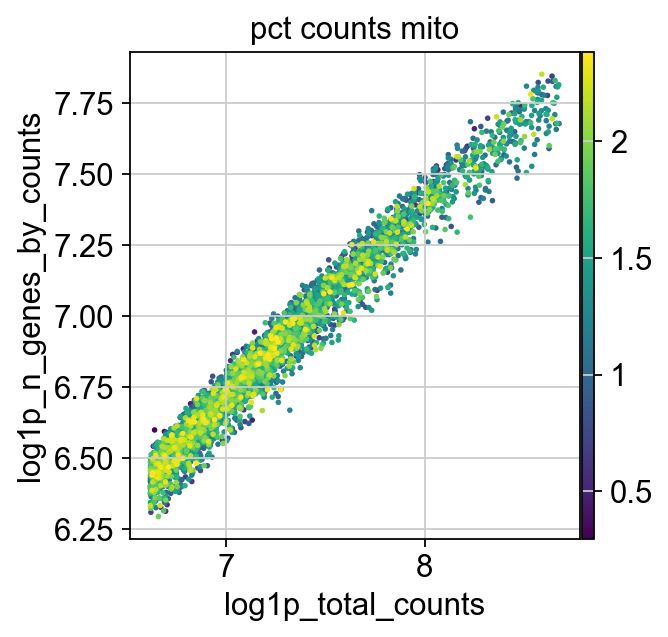

In [12]:
p4 = sc.pl.scatter(adata, "log1p_total_counts", "log1p_n_genes_by_counts", color="pct_counts_mito")

#### Questions
1. How many barcodes and genes are present in the dataset?  
2. What variable in the annData object indicates whether a gene (`.var`) is mitochondrial or not?
3. After `scanpy.pp.calculate_qc_metrics`, where were the calculated metrics they added?
4. If `nmad = 6`, how many outliers are identified based on the common qc metrics.
5. How many cells are left after filtering low quality barcodes?  

#### Questions & __Ansswers__
1. How many barcodes and genes are present in the dataset?  __The dataset has 5,218 barcodes and 35,682 transcripts.__
2. What variable in the annData object indicates whether a gene (`.var`) is mitochondrial or not? __`mito`__
3. After `scanpy.pp.calculate_qc_metrics`, where were the calculated metrics they added? __`.obs` and `.var` depending on metric measured__
4. If `nmad = 6`, how many outliers are identified based on the common qc metrics? __83; more lenient__  
5. How many cells are left after filtering low quality barcodes? __4754__  


#### 2.2 Correction of ambient RNA 

In [13]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'anndata2ri'

In [ ]:
%%R
library(SoupX)

In [ ]:
# Normalise and log1p-transform the data
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

In [ ]:
# Compute principal components
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

In [ ]:
del adata_pp

In [ ]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [ ]:
# Load the raw again
adata_raw = sc.read(f"{workdir}/data/E-MTAB-6945.h5ad")
data_tod = adata_raw.X.T

In [ ]:
del adata_raw

In [ ]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

In [ ]:
type(out)

In [ ]:
# Move counts to a layer
adata.layers["counts"] = adata.X

# Put the output of soupx into a layer
adata.layers["soupX_counts"] = out.T

# Use the soupx layer as the new main data layer, X
adata.X = adata.layers["soupX_counts"]

In [ ]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

The QC steps above filter the data into what can be considered the real RNAs.

Note: Above count for number of genes is not the same as the book. 

In [ ]:
# Save above data, so as not to repeat all of above when kernel stops
# adata.write("E-MTAB-6945_corrected_ambient_RNA.h5ad")

#### 2.3 Doublet Detection  

In [ ]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [ ]:
data_mat = adata.X.T

In [ ]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

In [ ]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

In [ ]:
# adata.write("E-MTAB-6945_quality_control.h5ad")

### 3. Normalization

In [ ]:
import scanpy as sc
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import anndata2ri
import logging
from scipy.sparse import issparse

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
adata = sc.read("E-MTAB-6945_quality_control.h5ad")
adata

In [ ]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

#### 3.1 Shifted logarithm

In [ ]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [ ]:
from scipy.sparse import csr_matrix, issparse

In [ ]:
%%R
library(scran)
library(BiocParallel)

In [ ]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

In [ ]:
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [ ]:
del adata_pp

In [ ]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [ ]:
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

In [ ]:
# adata.write("E-MTAB-6945_log1p_normalization.h5ad")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

In [ ]:
# adata.write("E-MTAB-6945_normalization.h5ad")

### 4. Feature Selection

In [ ]:
import scanpy as sc
import anndata2ri
import logging
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
%%R
library(scry)

In [ ]:
adata = sc.read("E-MTAB-6945_normalization.h5ad")

In [ ]:
ro.globalenv["adata"] = adata

In [ ]:
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [ ]:
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [ ]:
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance

In [ ]:
sc.pp.highly_variable_genes(adata, layer="scran_normalization")

In [ ]:
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

In [ ]:
# adata.write("E-MTAB-6945_feature_selection.h5ad")